#### Importing necessary libraries

In [1]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

#### Loading Data

In [58]:
# loading and viewing the dataset
df = pd.read_excel('premiums_rest.xlsx')
df['genetical_risk'] = 0
print(df.shape)
df.head()

(29904, 14)


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0


In [59]:
# cleaning up column names
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0


#### Handling NA values

In [60]:
# checking for null values
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [61]:
# handling the null values
df.dropna(inplace=True)
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [62]:
# checking for duplicates
df.duplicated().sum()

0

In [63]:
#summarizing the dataset
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.0
mean,43.396105,2.379910,23.364184,20892.303821,0.0
std,13.412657,1.431201,24.740339,6936.813440,0.0
min,26.000000,-3.000000,1.000000,3625.000000,0.0
25%,34.000000,1.000000,7.000000,15697.250000,0.0
50%,42.000000,3.000000,17.000000,20489.000000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,356.000000,5.000000,930.000000,43471.000000,0.0


#### Treating Outliers

In [64]:
## checking for outliers
df[df['number_of_dependants'] < 0].shape

(50, 14)

In [65]:
df[df['number_of_dependants'] < 0]['number_of_dependants'].unique()

array([-1, -3], dtype=int64)

In [66]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    29886.000000
mean         2.385933
std          1.421137
min          0.000000
25%          1.000000
50%          3.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

In [67]:
numeric_columns = df.select_dtypes(['float64', 'int64']).columns
numeric_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

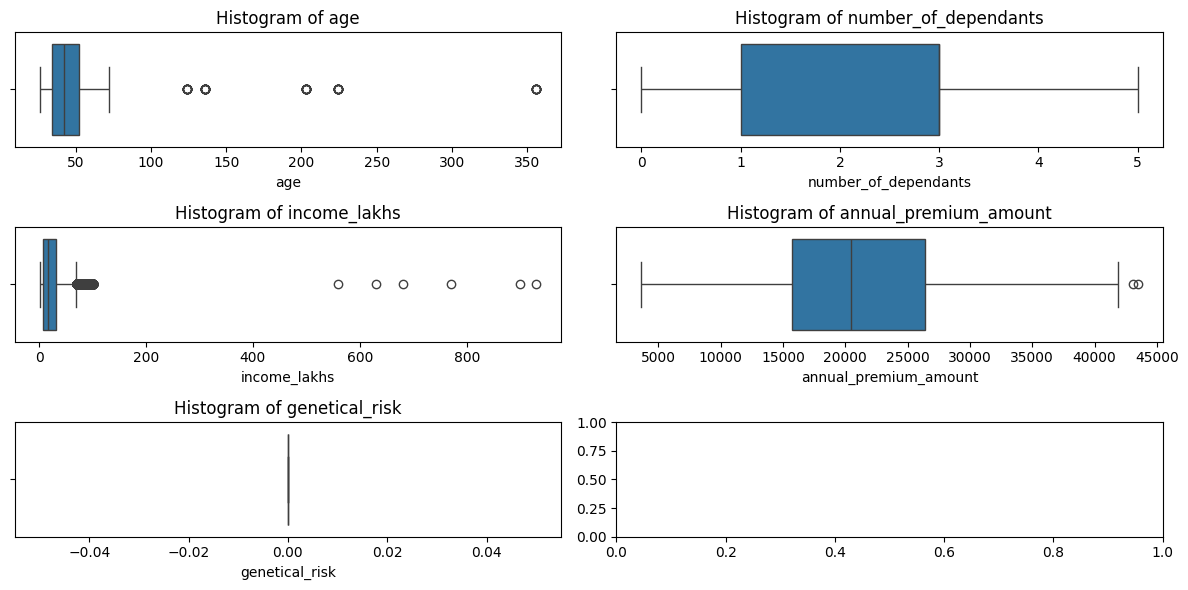

In [69]:
# Define the number of rows and columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 6))  # Adjust figure size as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through numeric columns and plot histograms
for i, col in enumerate(numeric_columns):
    sns.boxplot(df, x=col, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')  # Set title for each plot

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [70]:
df[df['age'] > 100].shape

(58, 14)

In [71]:
df[df['age'] > 100]['age'].unique()

array([224, 124, 136, 203, 356], dtype=int64)

In [72]:
df_new = df[df['age'] <= 100].copy()
df_new.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29828.000000,29828.000000,29828.000000,29828.000000,29828.0
mean,43.095380,2.387790,23.371530,20901.900563,0.0
std,11.041991,1.420641,24.751262,6928.457636,0.0
min,26.000000,0.000000,1.000000,6538.000000,0.0
25%,34.000000,1.000000,7.000000,15706.000000,0.0
50%,42.000000,3.000000,17.000000,20496.000000,0.0
75%,52.000000,3.000000,32.000000,26361.000000,0.0
max,72.000000,5.000000,930.000000,43471.000000,0.0


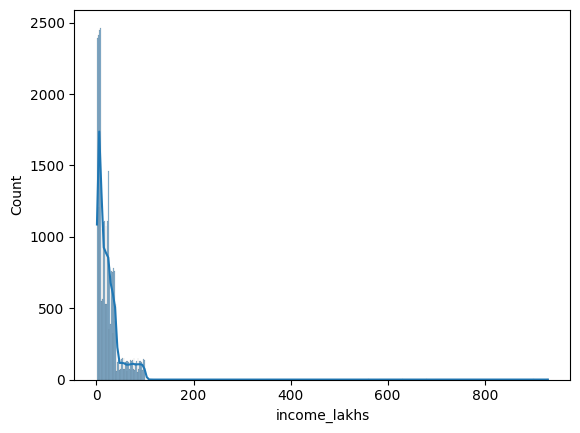

In [73]:
sns.histplot(df_new, x='income_lakhs', kde=True)
plt.show()

In [74]:
def get_iqr_bounds(col):
    q1, q3 = df_new[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

get_iqr_bounds('income_lakhs')

(-30.5, 69.5)

In [75]:
quantile_threshold = df_new['income_lakhs'].quantile(0.999)
df_new2 = df_new[df_new['income_lakhs'] <= quantile_threshold].copy()
df_new2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.0
mean,43.094896,2.387734,23.226343,20900.689223,0.0
std,11.042430,1.420644,22.455408,6928.192115,0.0
min,26.000000,0.000000,1.000000,6538.000000,0.0
25%,34.000000,1.000000,7.000000,15705.250000,0.0
50%,42.000000,3.000000,17.000000,20495.500000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,72.000000,5.000000,100.000000,43471.000000,0.0


#### Exploratory Data Analysis and Preparation

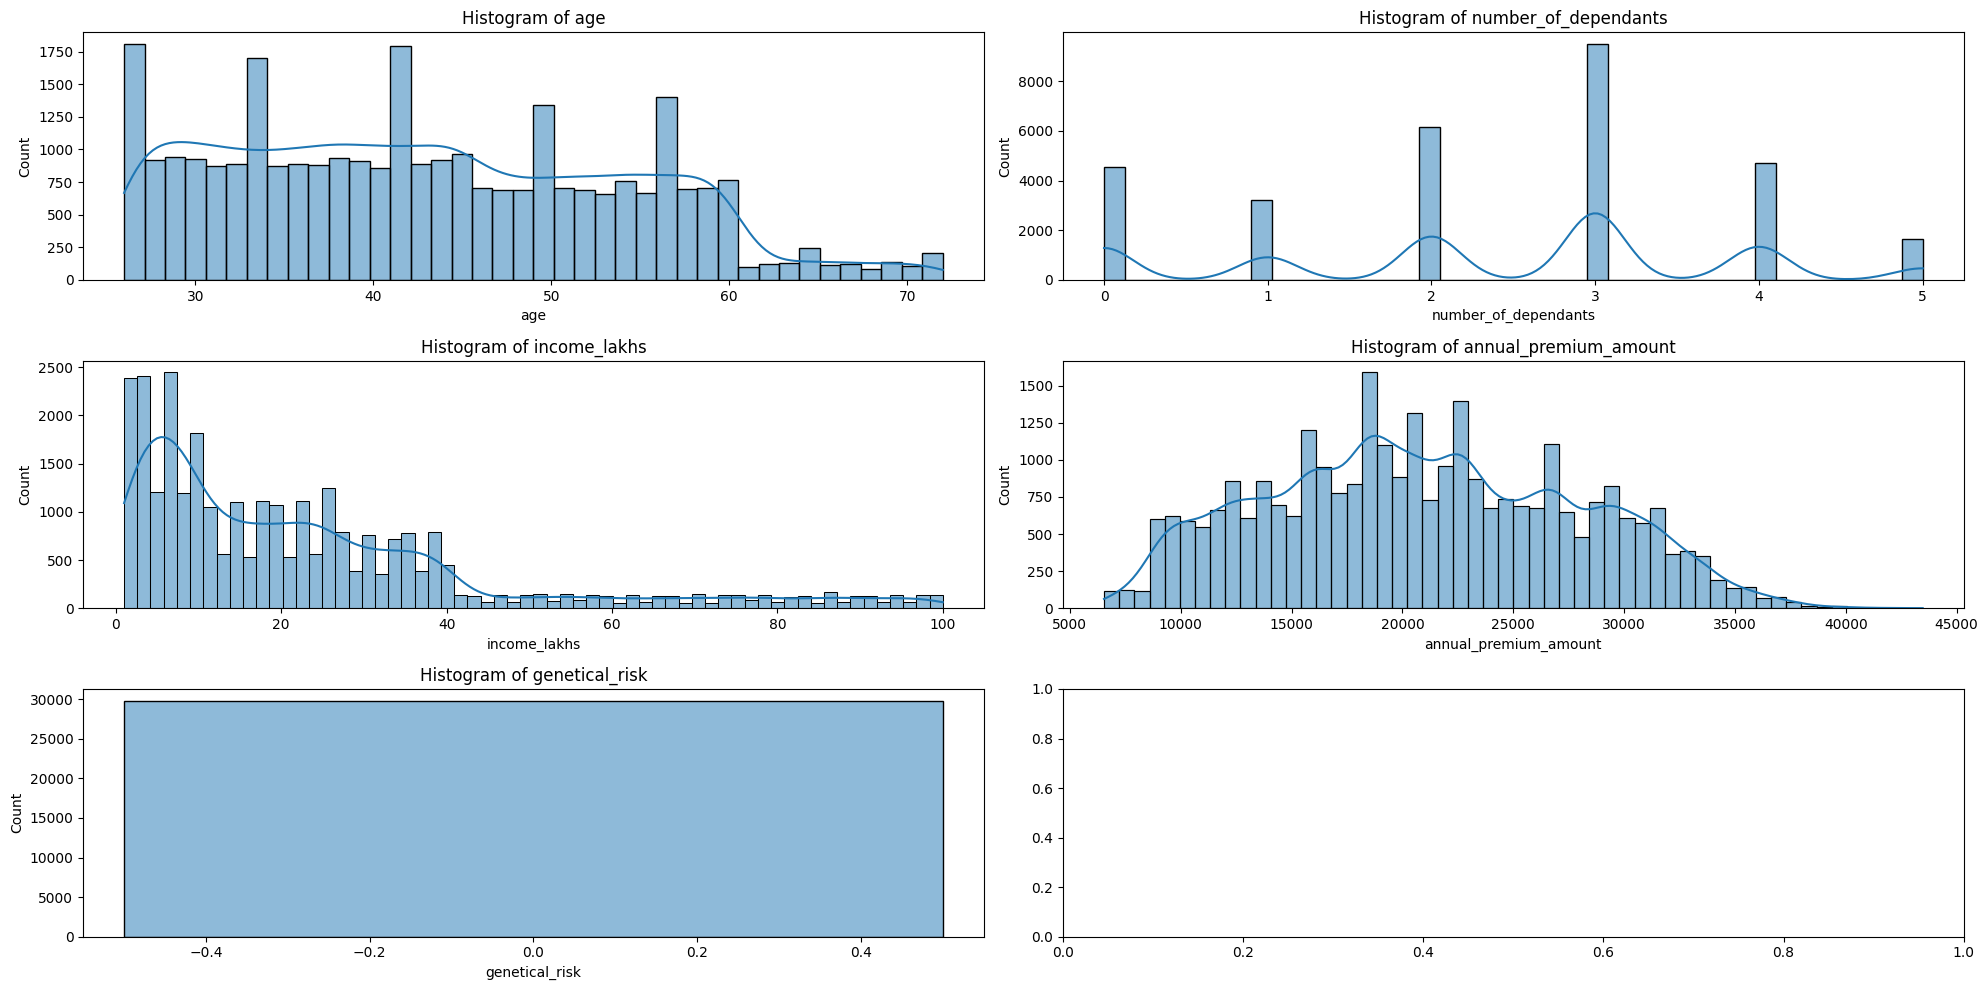

In [77]:
# Define the number of rows and columns
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))  # Adjust figure size as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through numeric columns and plot histograms
for i, col in enumerate(numeric_columns):
    sns.histplot(df_new2, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')  # Set title for each plot

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

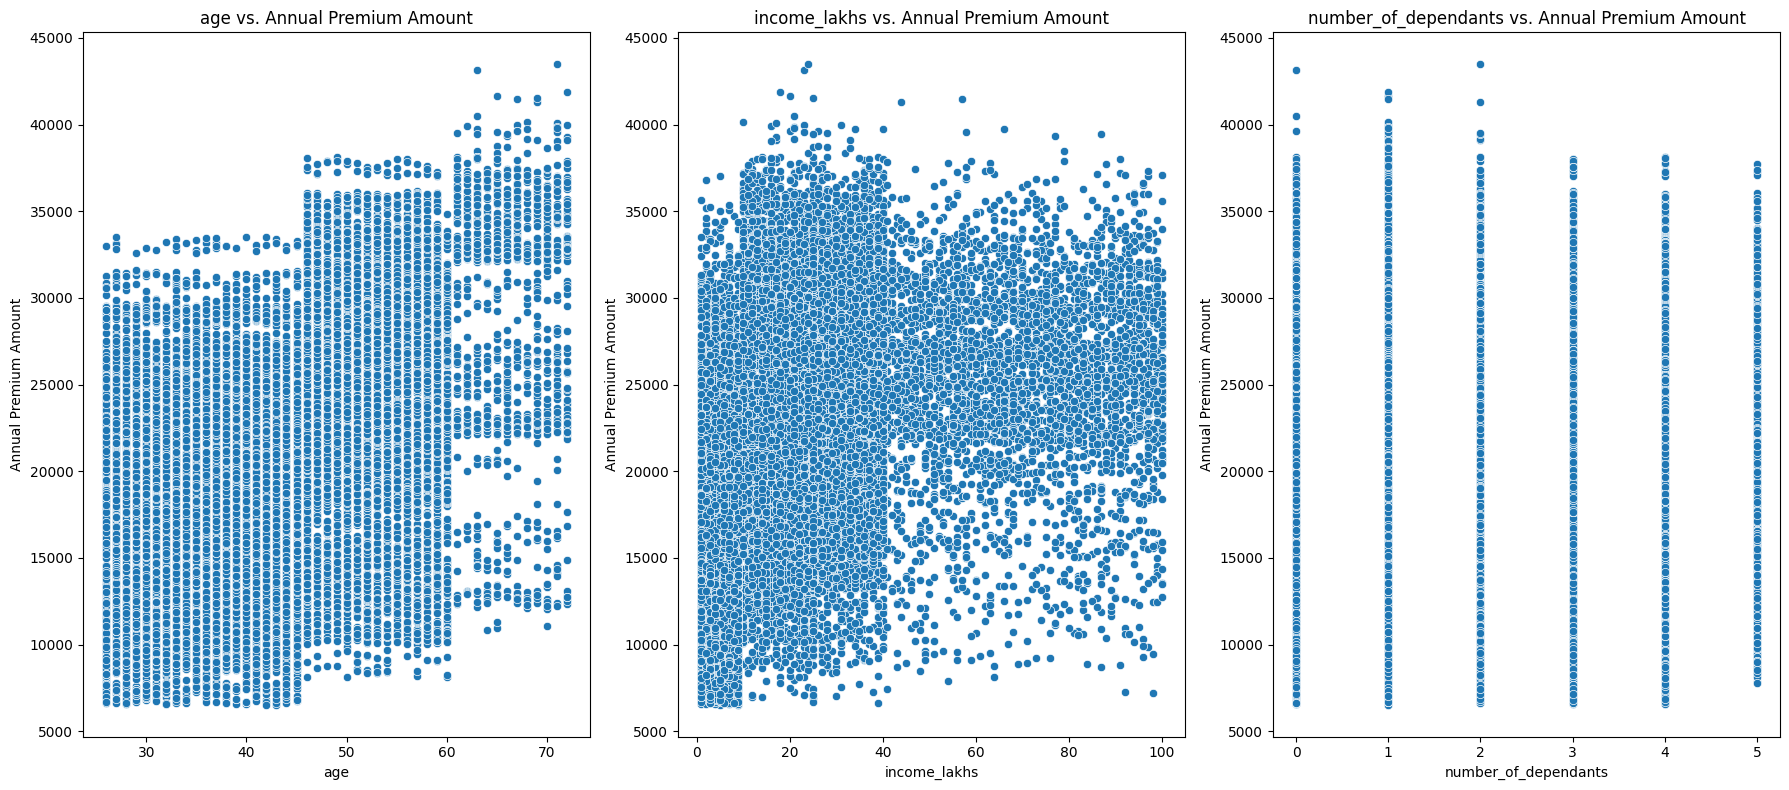

In [78]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']
fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 8))

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(df_new2, x=column, y='annual_premium_amount', ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()
plt.show()

In [79]:
categorical_cols = df.select_dtypes('object').columns
for col in categorical_cols:
    print(col, ":", df_new[col].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [80]:
# Treating inconsistent values
df_new['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke': 'No Smoking',
    'Not Smoking': 'No Smoking'
}, inplace=True)
df_new['smoking_status'].unique()

array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

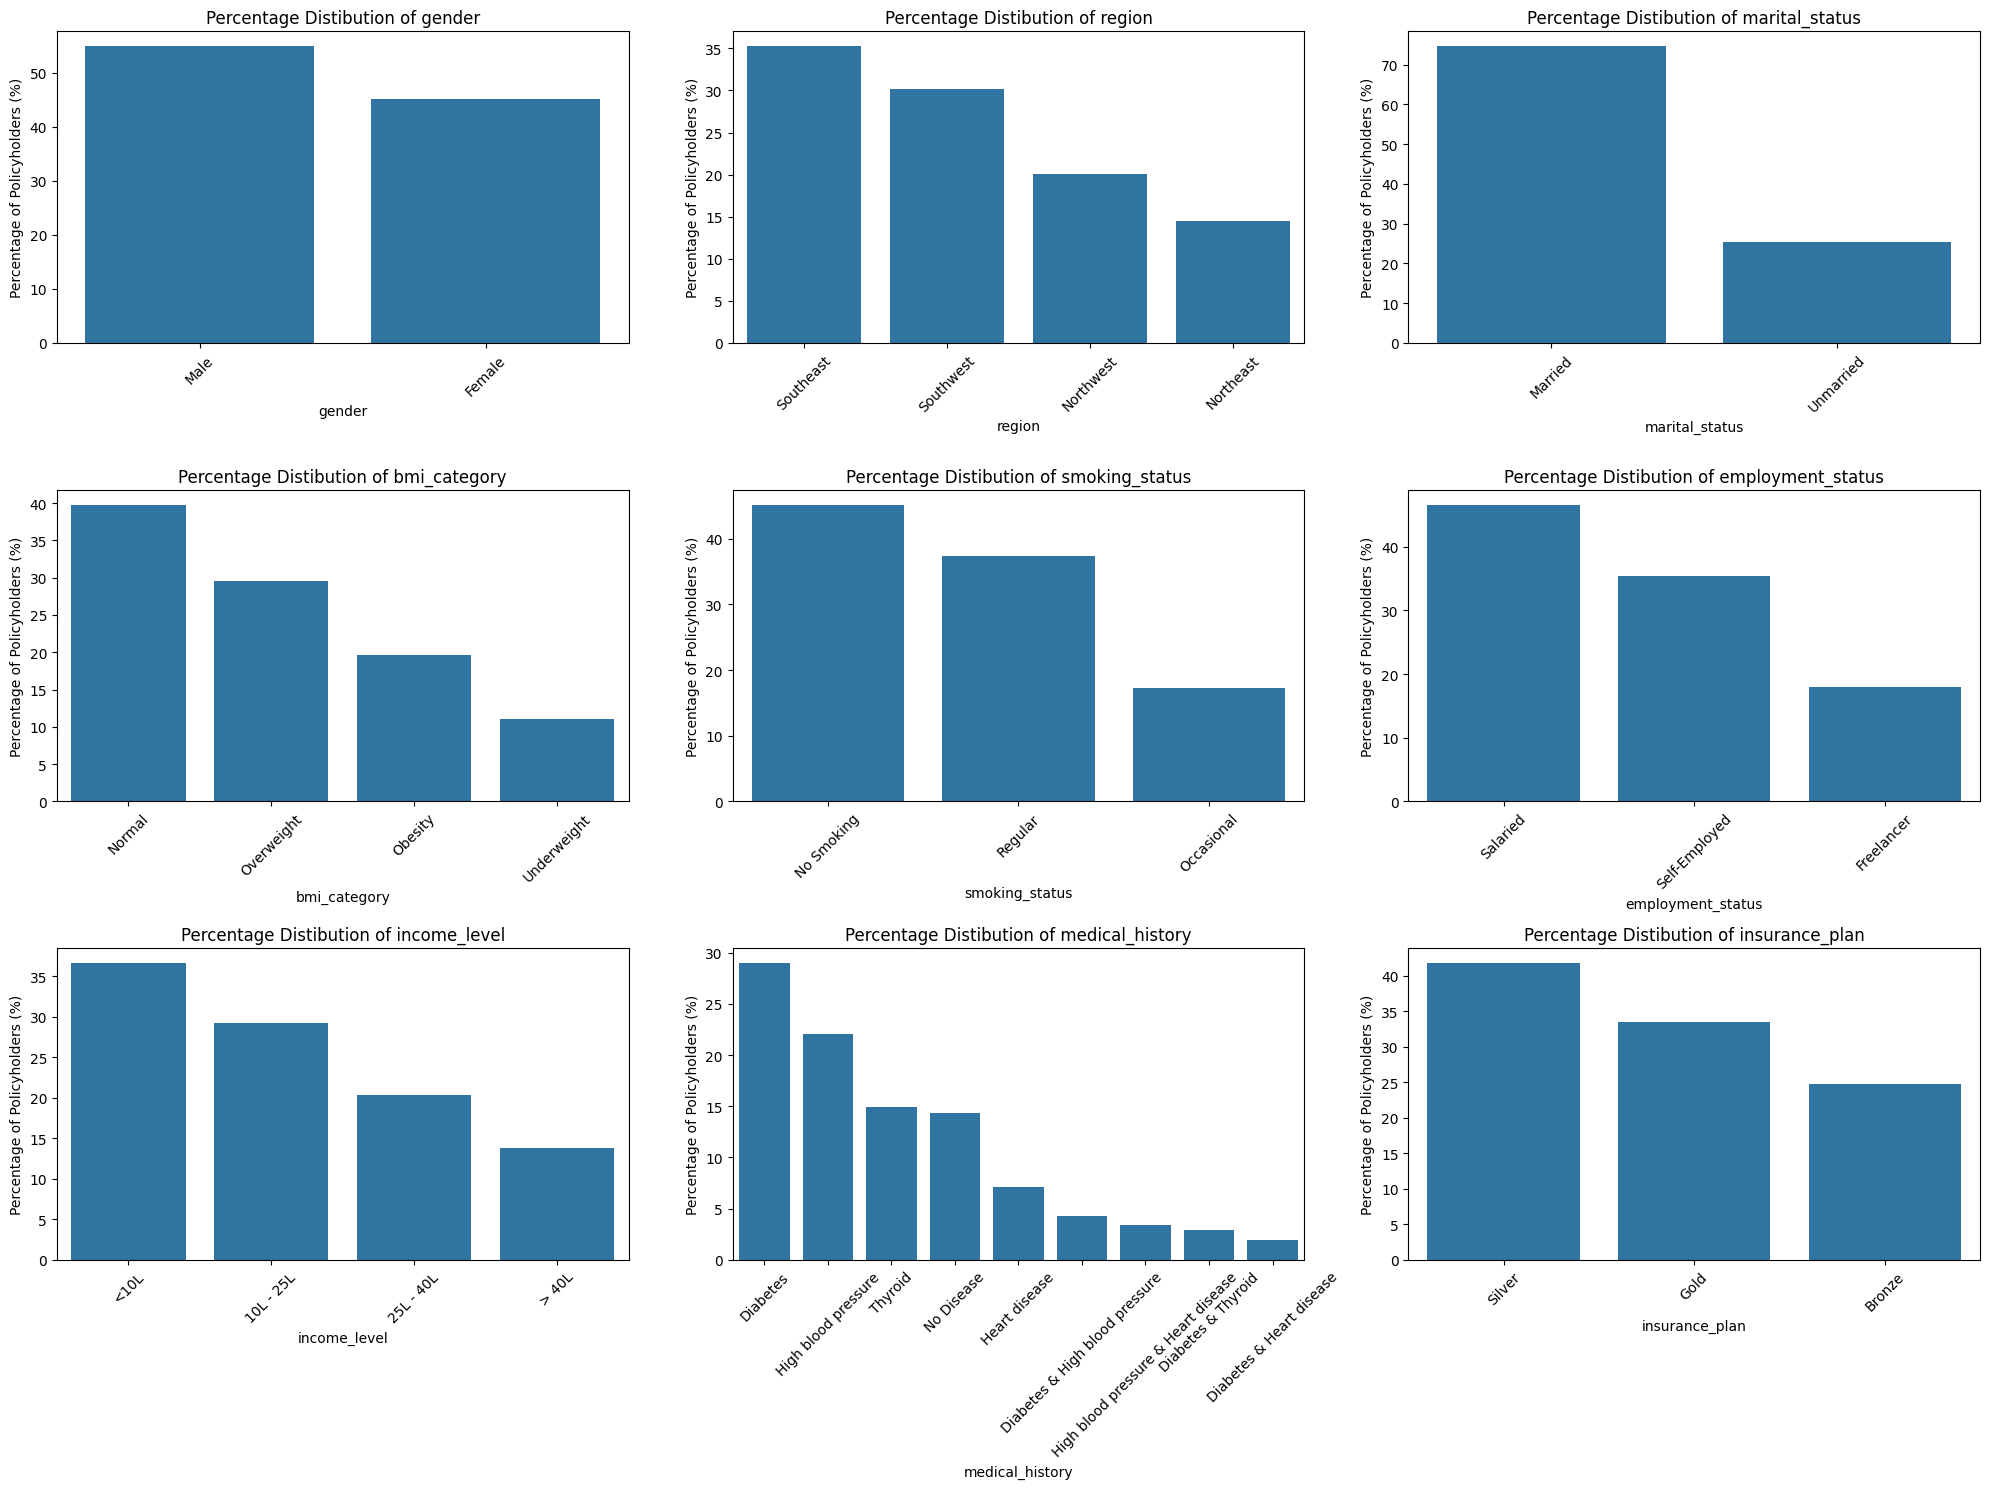

In [81]:
# Define the number of rows and columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))  # Adjust figure size as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through numeric columns and plot histograms
for ax, col in zip(axes,categorical_cols):
    cat_count = df_new[col].value_counts(normalize=True) * 100
    sns.barplot(x=cat_count.index, y=cat_count.values, ax=ax)
    ax.set_title(f'Percentage Distibution of {col}')  # Set title for each plot
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(col)
    ax.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

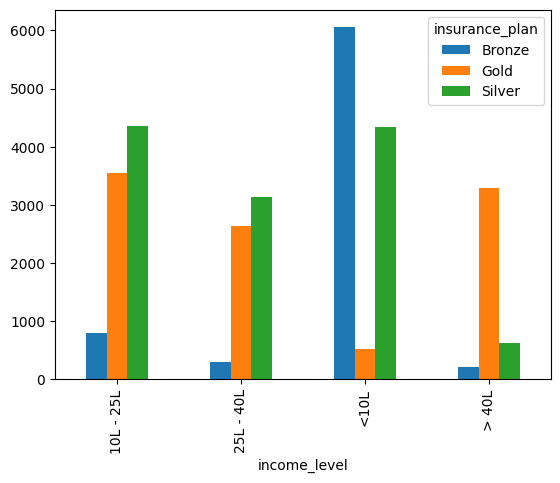

In [82]:
crosstab = pd.crosstab(df_new['income_level'], df_new['insurance_plan'])
crosstab.plot(kind='bar')
plt.show()

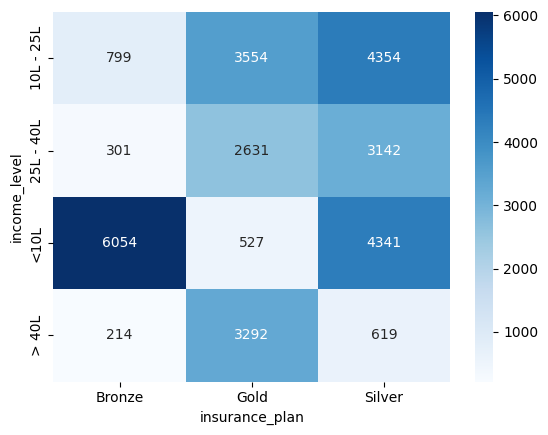

In [83]:
sns.heatmap(crosstab, fmt='d', cmap='Blues', annot=True)
plt.show()

#### Feature Engineering

In [84]:
df_new.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0


In [85]:
df_new['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [86]:
risk_scores = {
    'diabetes': 6,
    'heart disease': 8,
    'high blood pressure': 6,
    'thyroid': 5,
    'no disease': 0,
    'none': 0
}

df_new[['disease1', 'disease2']] = df_new['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df_new.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,None
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,None
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0,high blood pressure,None
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0,no disease,None
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0,diabetes,None


In [87]:
df_new['disease1'].fillna('none', inplace=True)
df_new['disease2'].fillna('none', inplace=True)
df_new['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df_new['total_risk_score'] += df_new[disease].map(risk_scores)

max_score = df_new  ['total_risk_score'].max()
min_score = df_new['total_risk_score'].min()
df_new['normalized_risk_score'] = (df_new['total_risk_score'] - min_score) / (max_score - min_score)
df_new.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0,no disease,none,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0,diabetes,none,6,0.428571


In [88]:
df_new['insurance_plan'] = df_new['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
df_new['insurance_plan'].unique()

array([1, 2, 3], dtype=int64)

In [89]:
df_new['income_level'] = df_new['income_level'].map({'<10L': 1, '10L - 25L': 2, '25L - 40L': 3, '> 40L': 4})
df_new['income_level'].unique()

array([1, 2, 4, 3], dtype=int64)

In [90]:
df_new['bmi_category'] = df_new['bmi_category'].map({'Underweight': 1, 'Normal': 2, 'Overweight': 3, 'Obesity': 4})
df_new['bmi_category'].unique()

array([2, 4, 3, 1], dtype=int64)

In [91]:
nominal_cols = ['gender', 'region', 'marital_status', 'smoking_status', 'employment_status']
df_new3 = pd.get_dummies(df_new, columns=nominal_cols, drop_first=True, dtype=int)
df_new3.head()

,age,number_of_dependants,bmi_category,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,...,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,2,1,6,Diabetes,1,9053,0,diabetes,...,0.428571,1,1,0,0,1,0,0,1,0
1,29,2,4,1,6,Diabetes,1,16339,0,diabetes,...,0.428571,0,0,1,0,0,0,1,1,0
2,49,2,2,2,20,High blood pressure,2,18164,0,high blood pressure,...,0.428571,0,0,0,0,0,0,0,0,1
3,30,3,2,4,77,No Disease,3,20303,0,no disease,...,0.000000,0,0,1,0,0,0,0,1,0
4,56,3,4,2,14,Diabetes,1,15610,0,diabetes,...,0.428571,1,0,0,0,0,1,0,0,1


In [92]:
df_new4 = df_new3.drop(['disease1', 'disease2', 'medical_history', 'total_risk_score'], axis=1)
df_new4.head()

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,2,1,6,1,9053,0,0.428571,1,1,0,0,1,0,0,1,0
1,29,2,4,1,6,1,16339,0,0.428571,0,0,1,0,0,0,1,1,0
2,49,2,2,2,20,2,18164,0,0.428571,0,0,0,0,0,0,0,0,1
3,30,3,2,4,77,3,20303,0,0.000000,0,0,1,0,0,0,0,1,0
4,56,3,4,2,14,1,15610,0,0.428571,1,0,0,0,0,1,0,0,1


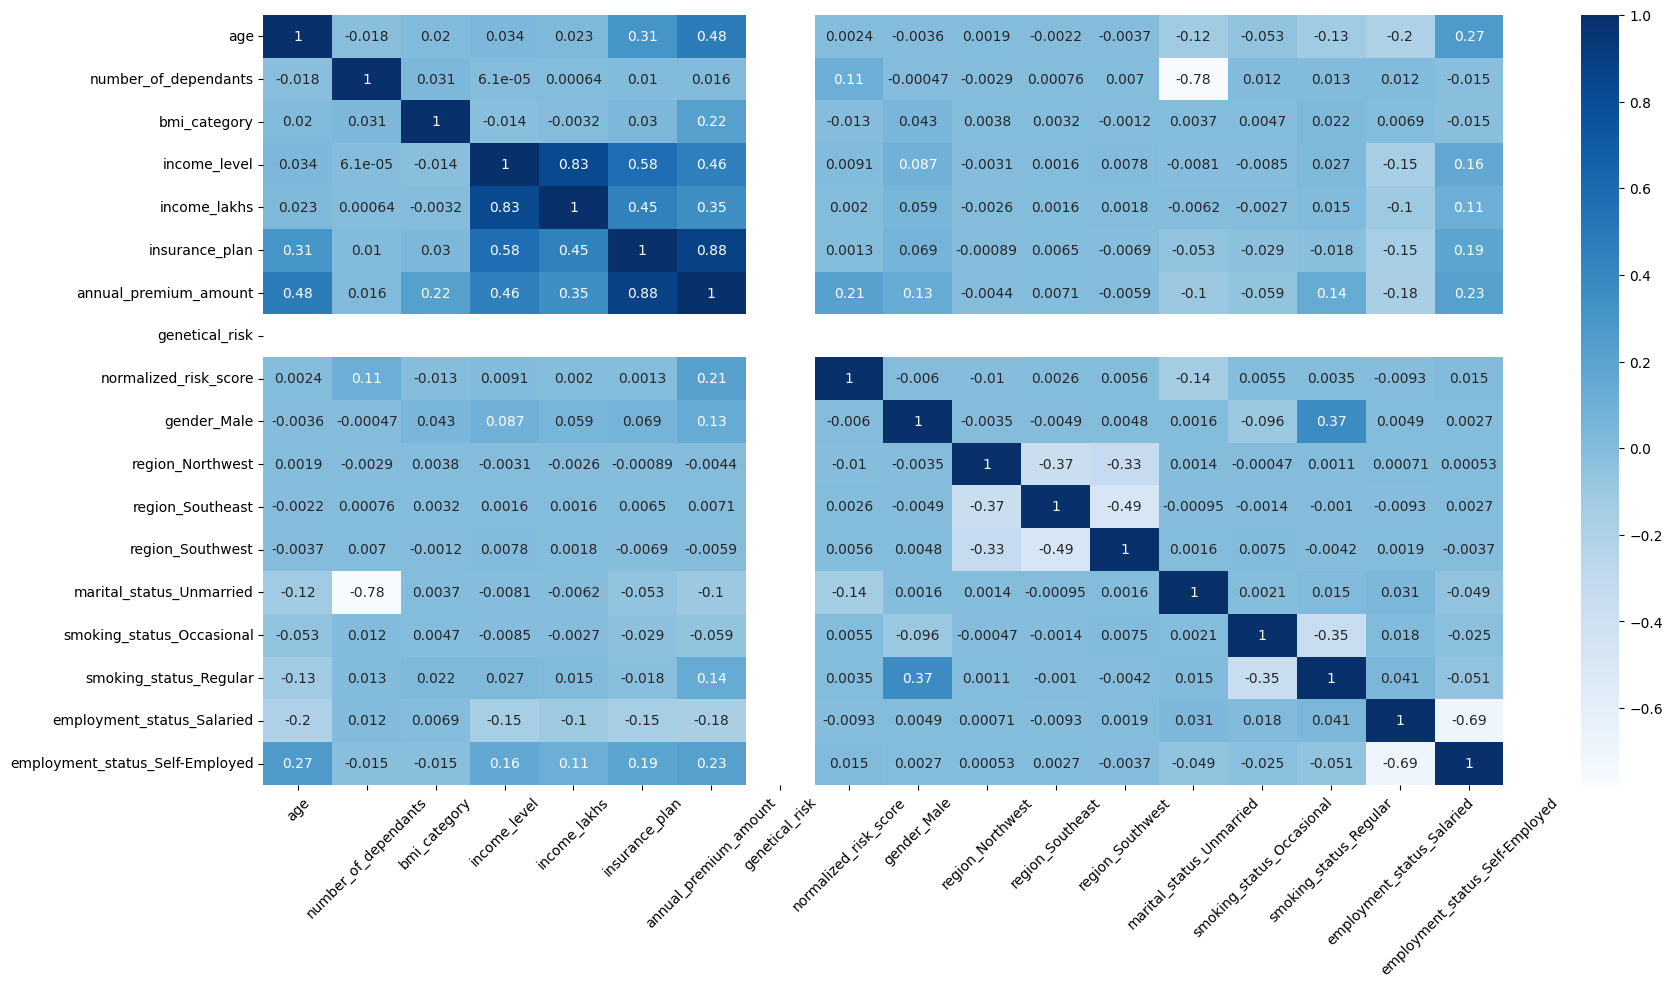

In [93]:
cm = df_new4.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xticks(rotation=45)
plt.show()

In [95]:
X = df_new4.drop(['annual_premium_amount'], axis=1)
y = df_new4['annual_premium_amount']

cols_to_scale = ['age','number_of_dependants', 'income_lakhs', 'income_level', 'insurance_plan', 'genetical_risk']
scaler = MinMaxScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

def calculate_vif(data):
    df_vif = pd.DataFrame()
    df_vif['Variables'] = data.columns
    df_vif['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return df_vif

calculate_vif(X)

,Variables,VIF
0,age,3.986482
1,number_of_dependants,6.972690
2,bmi_category,7.510783
3,income_level,8.495277
4,income_lakhs,5.948817
5,insurance_plan,5.267415
6,genetical_risk,NaN
7,normalized_risk_score,3.855436
8,gender_Male,2.588963
9,region_Northwest,2.161155


#### Model Training

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
train_score = lr_model.score(X_train, y_train)
test_score = lr_model.score(X_test, y_test)
print('Train score: ', train_score, 'Test score: ', test_score)

Train score:  0.9456890679630499 Test score:  0.9434469155809521


In [97]:
lr_model.intercept_

3618.5122573913286

In [98]:
lr_model.coef_

array([ 6.97812603e+03, -1.35300996e+03,  1.45281316e+03, -4.55656771e+02,
       -1.75899760e+03,  1.48769917e+04, -9.09494702e-13,  6.03181908e+03,
        8.74234181e+01, -5.37870785e+01,  8.73407954e+00, -6.86381477e+00,
       -7.35088500e+02,  8.27058062e+02,  2.79933385e+03, -3.50237273e+01,
        2.97671354e+02])

In [99]:
feature_importances = lr_model.coef_
coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
coef_df

,Coefficients
income_lakhs,-1.758998e+03
number_of_dependants,-1.353010e+03
marital_status_Unmarried,-7.350885e+02
income_level,-4.556568e+02
region_Northwest,-5.378708e+01
employment_status_Salaried,-3.502373e+01
region_Southwest,-6.863815e+00
genetical_risk,-9.094947e-13
region_Southeast,8.734080e+00
gender_Male,8.742342e+01


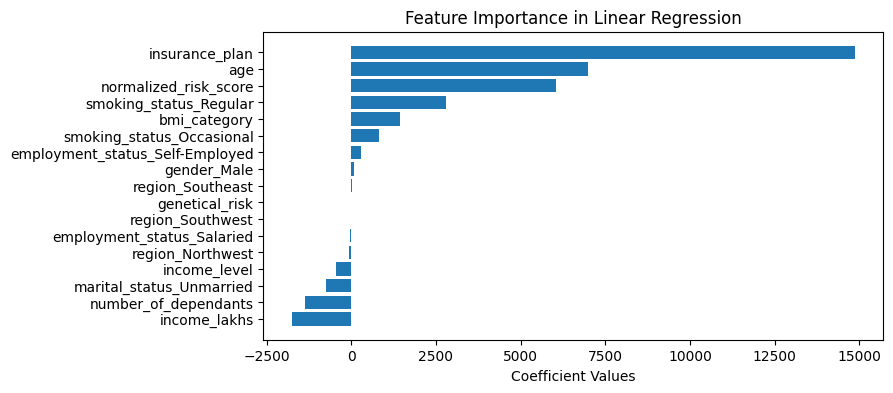

In [100]:
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'],)
plt.xlabel('Coefficient Values')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [101]:
rg_model = Ridge()
rg_model.fit(X_train, y_train)
train_score_rg = rg_model.score(X_train, y_train)
test_score_rg = rg_model.score(X_test, y_test)
print('Train score: ', train_score_rg, 'Test score: ', test_score_rg)

Train score:  0.9456883987591284 Test score:  0.9434439946201848


In [102]:
ls_model = Lasso()
ls_model.fit(X_train, y_train)
train_score_ls = ls_model.score(X_train, y_train)
test_score_ls = ls_model.score(X_test, y_test)
print('Train score: ', train_score_ls, 'Test score: ', test_score_ls)

Train score:  0.9456750989373784 Test score:  0.9434323033956351


In [103]:
xg_model = XGBRegressor()
xg_model.fit(X_train, y_train)
train_score_xg = xg_model.score(X_train, y_train)
test_score_xg = xg_model.score(X_test, y_test)
print('Train score: ', train_score_xg, 'Test score: ', test_score_xg)

Train score:  0.9986421465873718 Test score:  0.9980003237724304


In [104]:
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

rand_search = RandomizedSearchCV(xg_model, param_grid, cv=3, n_iter=10, scoring='r2', random_state=42)
rand_search.fit(X_train, y_train)
print(rand_search.best_score_)
print(rand_search.best_params_)

0.9971338907877604
{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}


In [105]:
best_model = rand_search.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

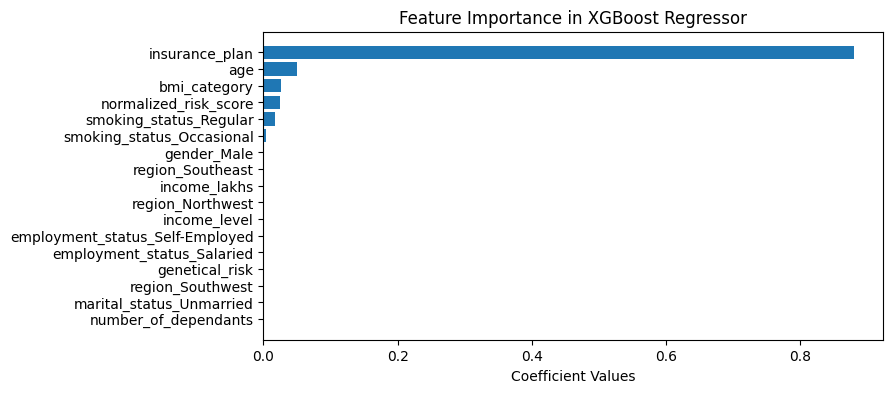

In [106]:
feature_importances = best_model.feature_importances_

coef_df = pd.DataFrame(feature_importances, index=X_test.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)
# coef_df

plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'],)
plt.xlabel('Coefficient Values')
plt.title('Feature Importance in XGBoost Regressor')
plt.show()

#### Error Analysis

In [107]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = residuals * 100 / y_test

result_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
})

result_df.head()

,actual,predicted,diff,diff_pct
25256,24958,24241.833984,-716.166016,-2.869485
28123,27608,27776.673828,168.673828,0.610960
10163,19860,19651.250000,-208.750000,-1.051108
27787,16892,16761.521484,-130.478516,-0.772428
15876,27190,27438.720703,248.720703,0.914751


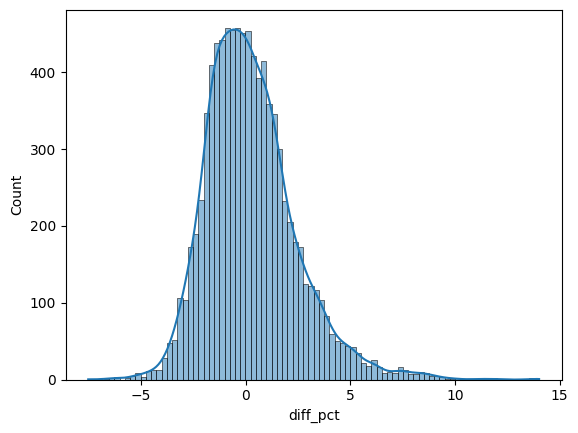

In [108]:
sns.histplot(result_df['diff_pct'], kde=True)
plt.show()

In [109]:
extreme_error_threshold = 10
extreme_result_df = result_df[abs(result_df['diff_pct']) > extreme_error_threshold]


In [110]:
extreme_error_pct = extreme_result_df.shape[0] * 100 / result_df.shape[0]
extreme_error_pct

0.11174432897530451

In [111]:
result_df[abs(result_df['diff_pct']) > 50].sort_values(by='diff_pct', ascending=False)

,actual,predicted,diff,diff_pct


In [112]:
extreme_error_df = X_test.loc[extreme_result_df.index]
extreme_error_df.head()

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
27518,0.304348,0.6,2,0.0,0.008611,0.0,0.0,0.357143,1,1,0,0,0,0,0,0,1
17811,0.130435,0.8,2,0.0,0.008611,0.0,0.0,0.000000,0,1,0,0,0,0,0,1,0
9787,0.043478,0.0,2,0.0,0.002153,0.0,0.0,0.357143,0,0,1,0,1,0,0,0,0
8288,0.130435,0.0,2,0.0,0.001076,0.0,0.0,0.000000,1,0,0,1,1,0,0,0,0
10741,0.173913,0.6,2,0.0,0.000000,0.0,0.0,0.000000,0,1,0,0,0,0,0,1,0


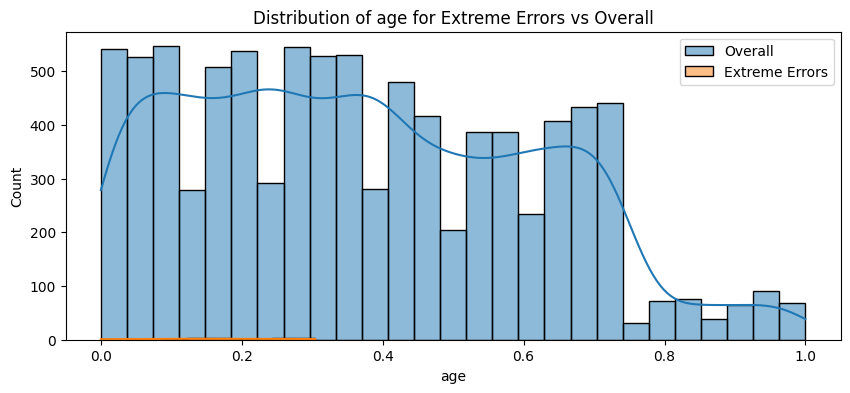

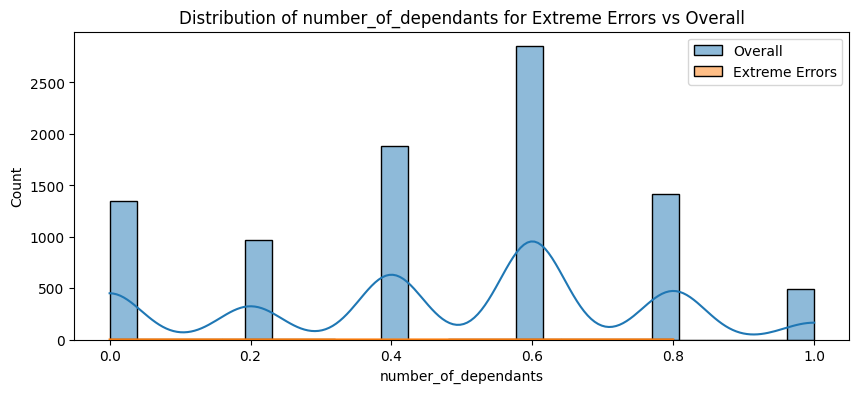

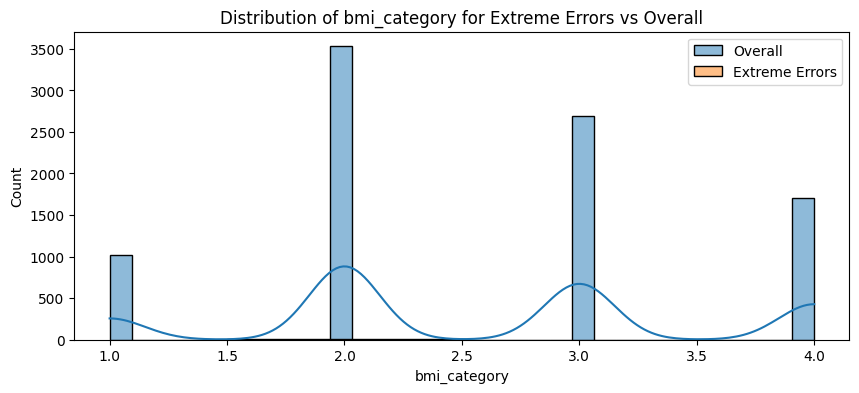

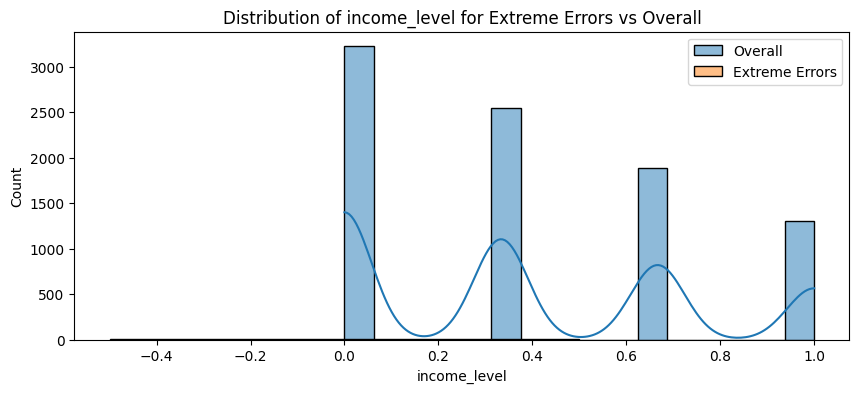

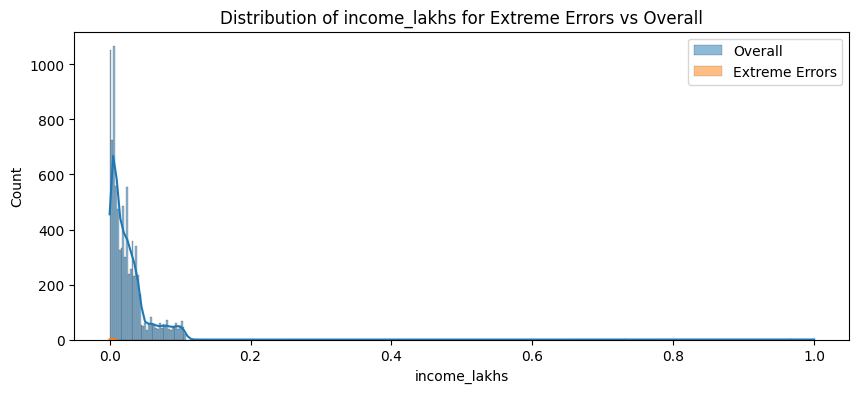

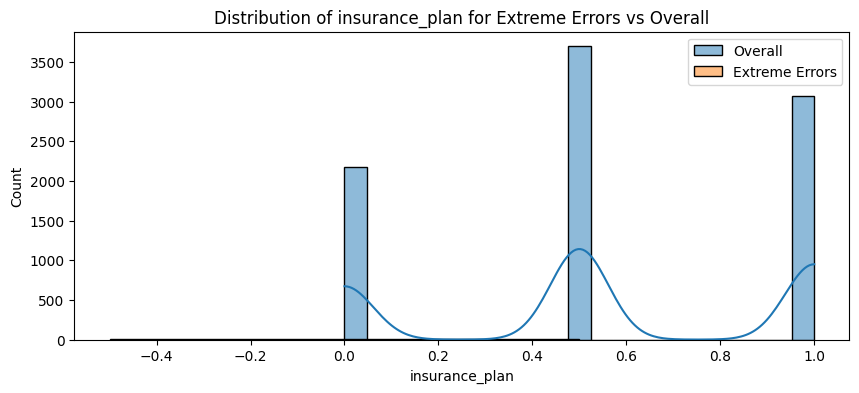

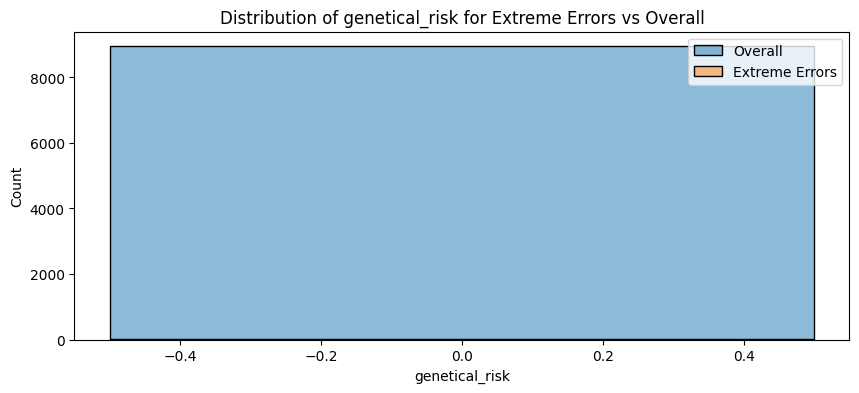

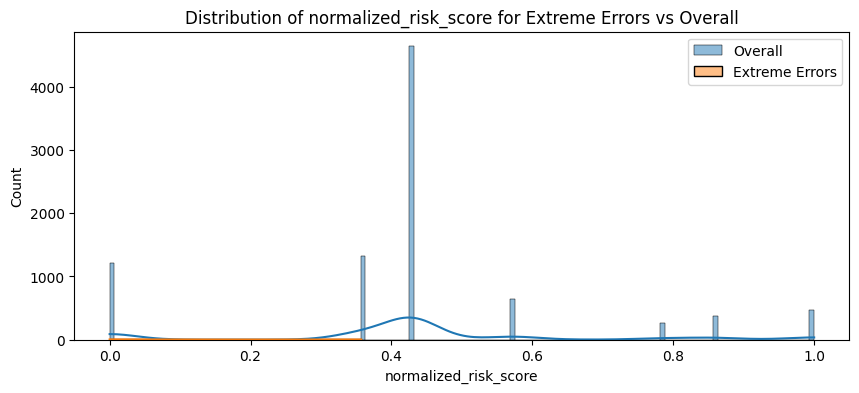

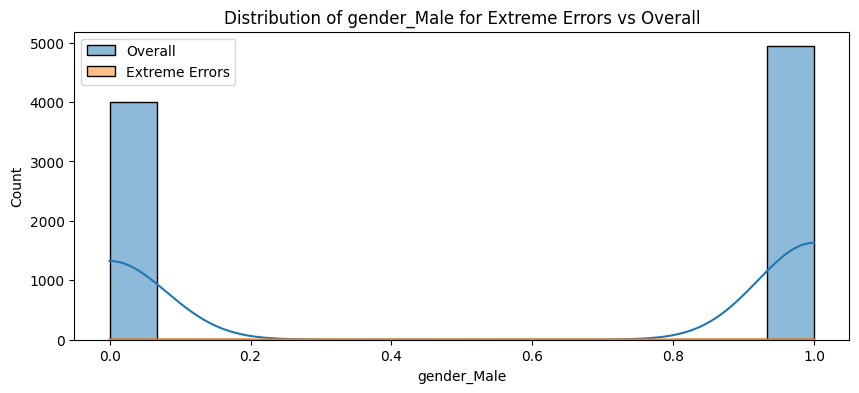

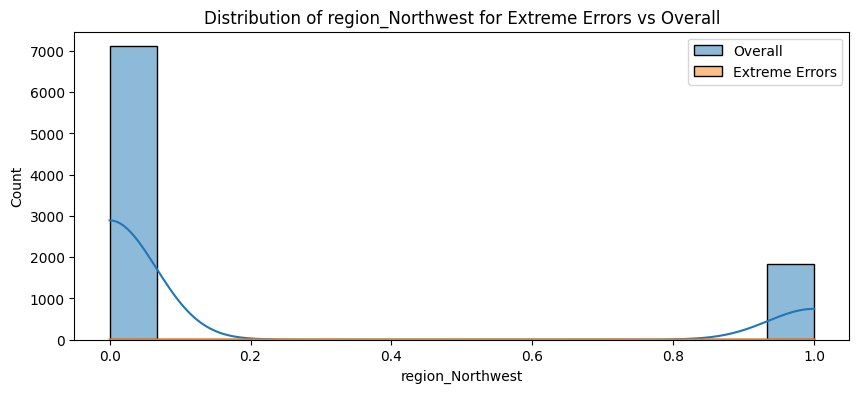

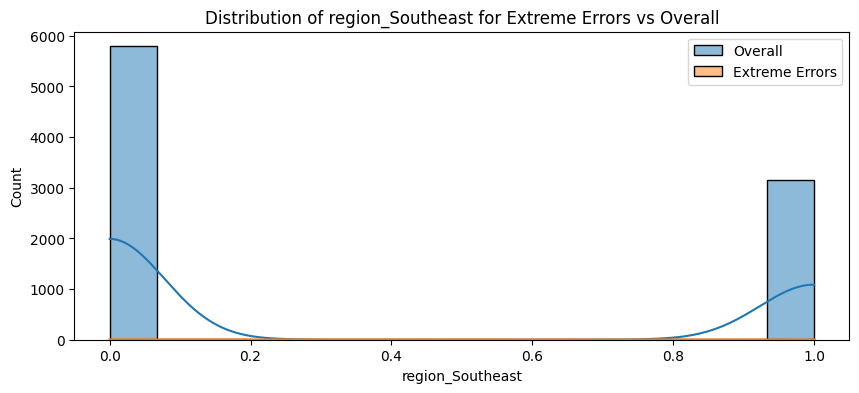

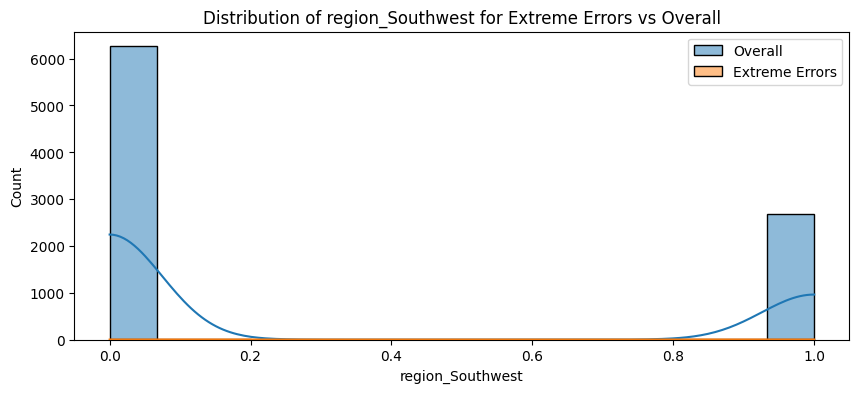

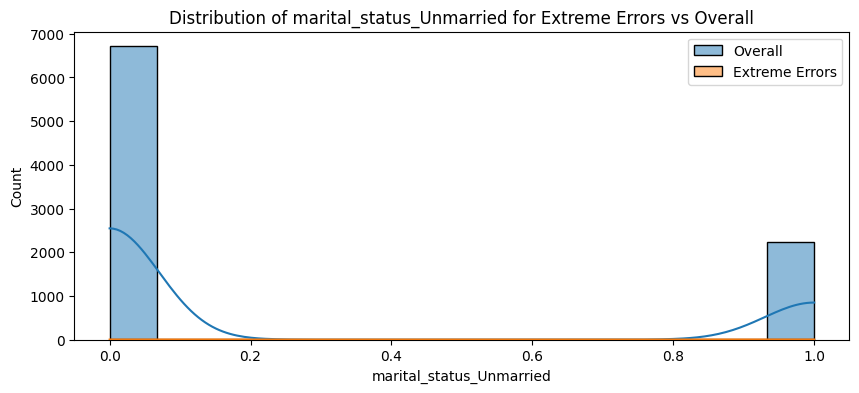

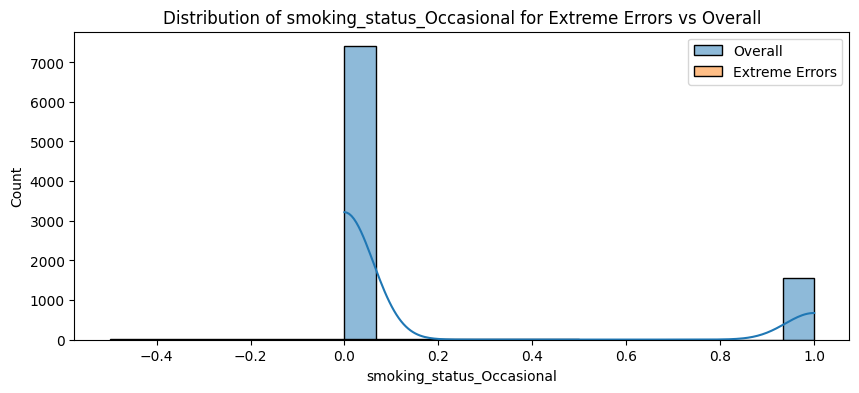

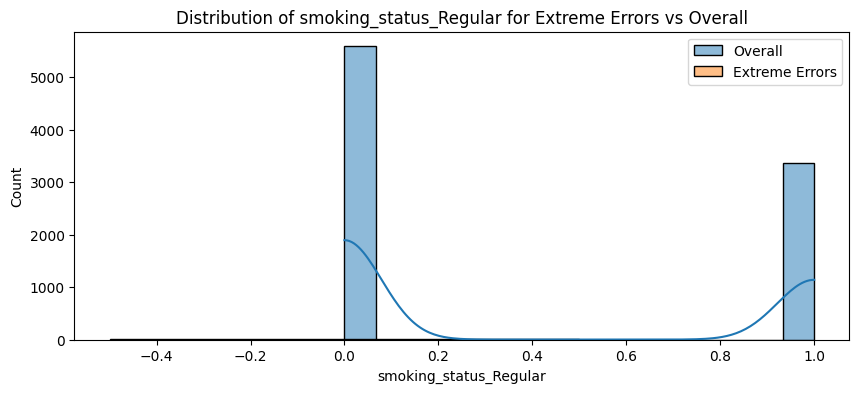

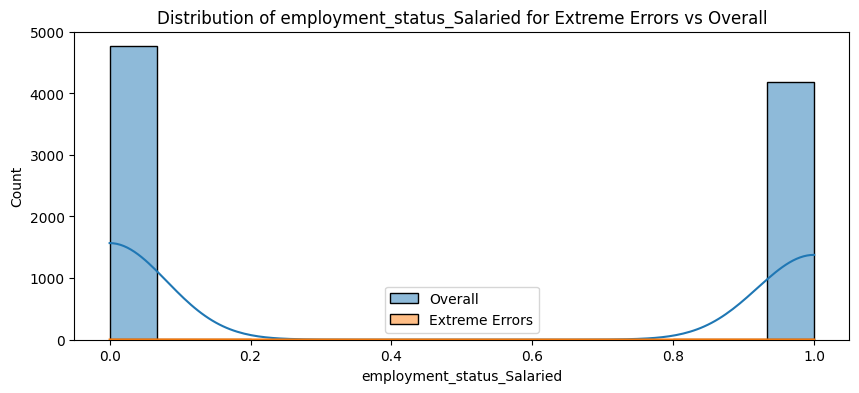

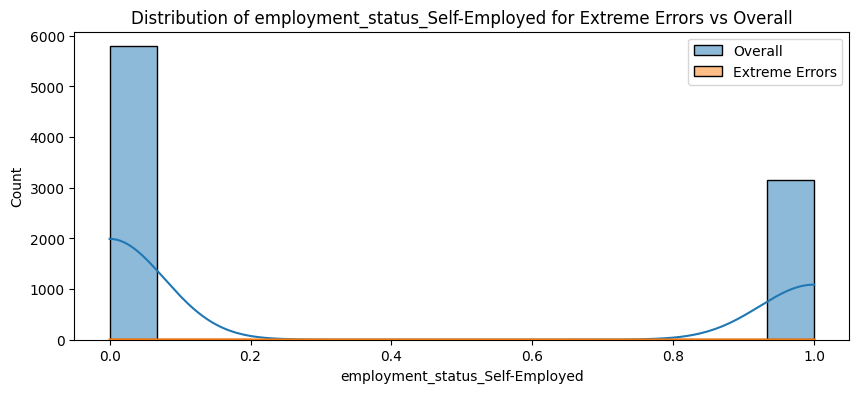

In [113]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(X_test[feature], label='Overall', kde=True)
    sns.histplot(extreme_error_df[feature], label='Extreme Errors', alpha=0.5, kde=True)
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.legend()
    plt.show()

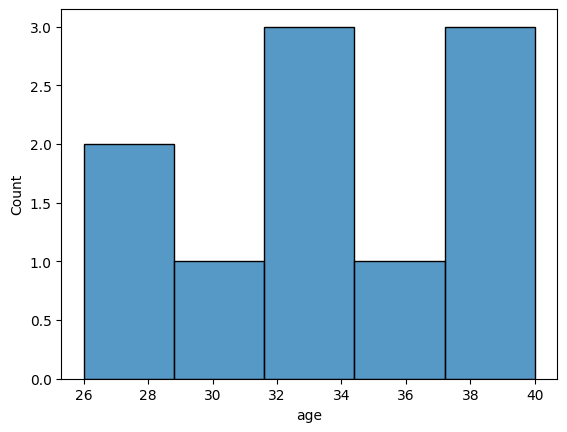

In [114]:
df_reversed = pd.DataFrame(scaler.inverse_transform(extreme_error_df[cols_to_scale]), columns=cols_to_scale)
original_age = df_reversed['age']
sns.histplot(original_age)
plt.show()

In [115]:
df_reversed.describe()

,age,number_of_dependants,income_lakhs,income_level,insurance_plan,genetical_risk
count,10.000000,10.00000,10.000000,10.0,10.0,10.0
mean,33.900000,2.10000,5.700000,1.0,1.0,0.0
std,5.043147,1.66333,3.233505,0.0,0.0,0.0
min,26.000000,0.00000,1.000000,1.0,1.0,0.0
25%,31.250000,1.00000,3.250000,1.0,1.0,0.0
50%,33.000000,2.00000,5.500000,1.0,1.0,0.0
75%,39.000000,3.75000,9.000000,1.0,1.0,0.0
max,40.000000,4.00000,9.000000,1.0,1.0,0.0


In [116]:
df_reversed['age'].quantile(0.97)

40.0

#### Exporting Model

In [117]:
from joblib import dump
dump(best_model, 'artifacts/model_rest.joblib')

['artifacts/model_rest.joblib']

In [118]:
scaler_with_cols = {
    'scaler': scaler,
    'cols_to_scale': cols_to_scale
}

dump(scaler_with_cols, 'artifacts/scaler_rest.joblib')

['artifacts/scaler_rest.joblib']